In [1]:
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import dill

color_dict = {0:'red', 1:'blue', 2:'green'}
sns.set()
num = 200

/home/analytics/anaconda3/envs/struct/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/analytics/anaconda3/envs/struct/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/analytics/anaconda3/envs/struct/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/analytics/anaconda3/envs/struct/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def load_dill(fname):
    with open(fname, 'rb') as f:
        return dill.load(f)
    
def dump_dill(fname, obj):
    with open(fname, 'wb') as f:
        dill.dump(obj, f)
    return None

def tune_lr_model(X_train, y_train):
    params = {'penalty':['l1','l2'],
              'C':[0.001, 0.01, 0.1, 1.0],
              'class_weight':[None, 'balanced']}
    clf = LogisticRegression()
    gs = GridSearchCV(clf, params, scoring='accuracy', cv=3, refit=True)
    gs.fit(X_train, y_train)
    return gs.best_estimator_

def tune_knn_model(X_train, y_train):
    params = {'n_neighbors':[1,2,5,10,20],
              'weights':['uniform','distance'],
              'p':[1,2,3]}
    clf = KNeighborsClassifier()
    gs = GridSearchCV(clf, params, scoring='accuracy', cv=3, refit=True)
    gs.fit(X_train, y_train)
    return gs.best_estimator_

def tune_rf_model(X_train, y_train):
    params = {'n_estimators':[10,20,50],
              'max_depth':[3,4,5,None],
              'min_samples_split':[2,5,10],
              'class_weight':['balanced',None]}
    clf = RandomForestClassifier()
    gs = GridSearchCV(clf, params, scoring='accuracy', cv=3, refit=True)
    gs.fit(X_train, y_train)
    return gs.best_estimator_

# Blob data

In [3]:
data = load_dill('blobs/blobs_nnar_0.10.dill')
X = data['X']
y = data['y']
y_nnars = data['y_new'][:num]
y_fig = y_nnars[0]

Baseline performance

In [4]:
base_scores = []
idx = np.arange(y.shape[0])
for i in tqdm(range(num)):
    idx_train, idx_test = train_test_split(idx, test_size=0.3, stratify=y, random_state=i)
    clf = LogisticRegression().fit(X[idx_train], y[idx_train])
    y_pred = clf.predict(X[idx_test])
    base_scores.append(accuracy_score(y[idx_test], y_pred))
base_scores = np.array(base_scores)

100%|██████████| 200/200 [00:01<00:00, 177.90it/s]


Apparent performance

In [5]:
idx = np.arange(y.shape[0])
scores = []
true_scores = []
for i, y_nnar in enumerate(tqdm(y_nnars)):
    idx_train, idx_test = train_test_split(idx, test_size=0.3, stratify=y_nnar, random_state=i)
    clf = LogisticRegression().fit(X[idx_train], y_nnar[idx_train])
    y_pred = clf.predict(X[idx_test])
    scores.append(accuracy_score(y_nnar[idx_test], y_pred))
    true_scores.append(accuracy_score(y[idx_test], y_pred))
scores = np.array(scores)
true_scores = np.array(true_scores)

100%|██████████| 200/200 [00:01<00:00, 175.60it/s]


Apparent performance vs noise

In [6]:
dataset ='blobs'
noise_type = 'nnar'
thresholds = np.arange(0.01, 0.21, 0.01)
stats_scores = []
stats_true_scores = []
for threshold in thresholds:
    print('noise_level = %0.2f' % threshold)
    # Load data
    data = load_dill('%s/%s_%s_%0.2f.dill' % (dataset, dataset, noise_type, threshold))
    X = data['X']
    y = data['y']
    y_nnars = data['y_new'][:num]
    
    idx = np.arange(y.shape[0])
    sub_scores = []
    sub_true_scores = []
    for i, y_nnar in enumerate(tqdm(y_nnars)):
        idx_train, idx_test = train_test_split(idx, test_size=0.3, stratify=y_nnar, random_state=i)
        clf = LogisticRegression().fit(X[idx_train], y_nnar[idx_train])
        y_pred = clf.predict(X[idx_test])
        sub_scores.append(accuracy_score(y_nnar[idx_test], y_pred))
        sub_true_scores.append(accuracy_score(y[idx_test], y_pred))
    stats_scores.append(np.percentile(sub_scores, [5,50,95]))
    stats_true_scores.append(np.percentile(sub_true_scores, [5,50,95]))
stats_scores = np.array(stats_scores)
stats_true_scores = np.array(stats_true_scores)

  8%|▊         | 17/200 [00:00<00:01, 169.47it/s]

noise_level = 0.01


  8%|▊         | 17/200 [00:00<00:01, 163.35it/s]

noise_level = 0.02


  9%|▉         | 18/200 [00:00<00:01, 171.98it/s]

noise_level = 0.03


  9%|▉         | 18/200 [00:00<00:01, 172.71it/s]

noise_level = 0.04


  9%|▉         | 18/200 [00:00<00:01, 172.57it/s]

noise_level = 0.05


 10%|▉         | 19/200 [00:00<00:00, 182.06it/s]

noise_level = 0.06


 10%|▉         | 19/200 [00:00<00:01, 180.87it/s]

noise_level = 0.07


 10%|▉         | 19/200 [00:00<00:00, 182.37it/s]

noise_level = 0.08


 10%|▉         | 19/200 [00:00<00:00, 182.06it/s]

noise_level = 0.09


 10%|▉         | 19/200 [00:00<00:00, 182.33it/s]

noise_level = 0.10


 10%|▉         | 19/200 [00:00<00:00, 181.95it/s]

noise_level = 0.11


 10%|▉         | 19/200 [00:00<00:00, 182.55it/s]

noise_level = 0.12


 10%|▉         | 19/200 [00:00<00:00, 182.12it/s]

noise_level = 0.13


 10%|▉         | 19/200 [00:00<00:00, 182.00it/s]

noise_level = 0.14


 10%|▉         | 19/200 [00:00<00:01, 176.96it/s]

noise_level = 0.15


 10%|▉         | 19/200 [00:00<00:00, 183.35it/s]

noise_level = 0.16


  9%|▉         | 18/200 [00:00<00:01, 174.98it/s]

noise_level = 0.17


 10%|▉         | 19/200 [00:00<00:01, 180.30it/s]

noise_level = 0.18


  8%|▊         | 16/200 [00:00<00:01, 155.51it/s]

noise_level = 0.19


  9%|▉         | 18/200 [00:00<00:01, 177.16it/s]

noise_level = 0.20


100%|██████████| 200/200 [00:01<00:00, 174.44it/s]


Generate figures

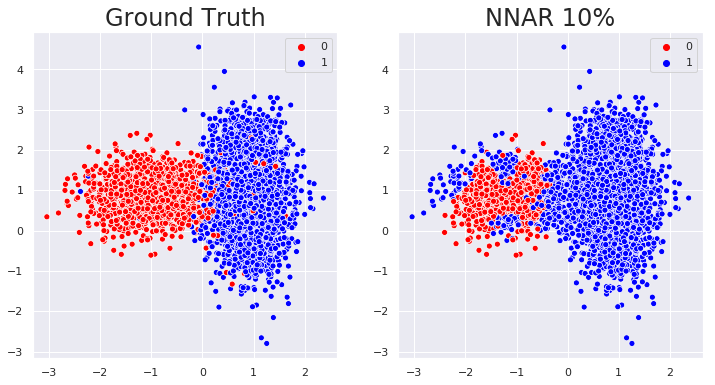

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(X[:,0], X[:,1], hue=y, ax=axes[0], palette=color_dict)
sns.scatterplot(X[:,0], X[:,1], hue=y_fig, ax=axes[1], palette=color_dict)
axes[0].set_title('Ground Truth', fontsize=24)
axes[1].set_title('NNAR 10%', fontsize=24)
# plt.show()
plt.savefig('%s_%s_0.10_viz.png' % (dataset, noise_type))

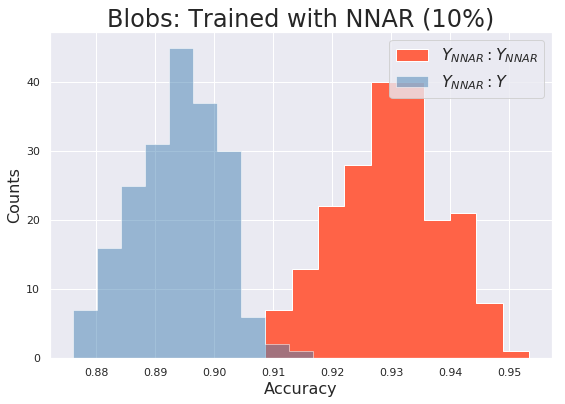

In [8]:
plt.figure(figsize=(9,6))
plt.hist(scores, label='$Y_{NNAR}:Y_{NNAR}$', color='tomato', histtype='stepfilled')
plt.hist(true_scores, label='$Y_{NNAR}:Y$', color='steelblue', histtype='stepfilled', alpha=0.5)
plt.title('Blobs: Trained with NNAR (10%)', fontsize=24)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.legend(loc='best', fontsize=16)
# plt.show()
plt.savefig('%s_%s_0.10.png' % (dataset, noise_type))

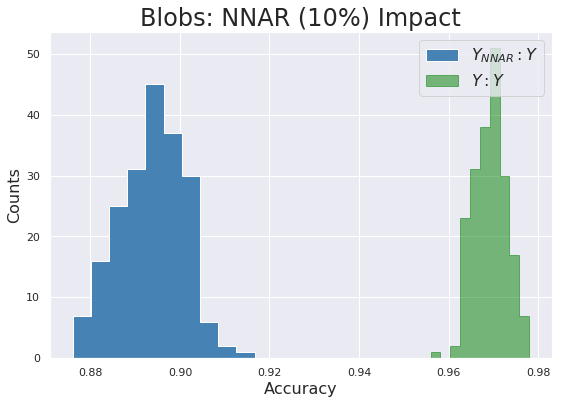

In [9]:
plt.figure(figsize=(9,6))
plt.hist(true_scores, label='$Y_{NNAR}:Y$', color='steelblue', histtype='stepfilled')
plt.hist(base_scores, label='$Y:Y$', color='green', edgecolor='green', histtype='stepfilled', alpha=0.5)
plt.title('Blobs: NNAR (10%) Impact', fontsize=24)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.legend(loc='best', fontsize=16)
# plt.show()
plt.savefig('%s_%s_0.10_impact.png' % (dataset, noise_type))

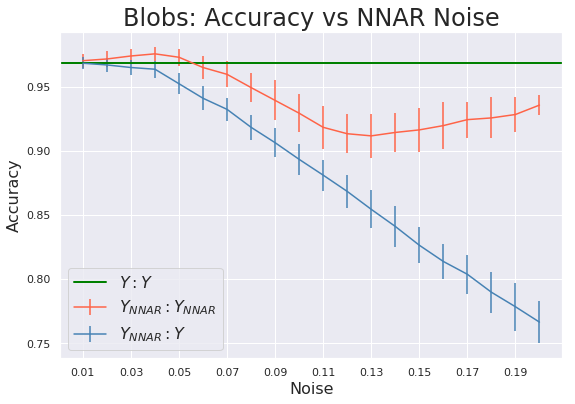

In [10]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, stats_scores[:,1], stats_scores[:,1] - stats_scores[:,0], color='tomato', label='$Y_{NNAR}:Y_{NNAR}$')
plt.errorbar(thresholds, stats_true_scores[:,1], stats_true_scores[:,1] - stats_true_scores[:,0], color='steelblue', label='$Y_{NNAR}:Y$')
plt.axhline(base_scores.mean(), color='green', lw=2, label='$Y:Y$')
plt.title('Blobs: Accuracy vs NNAR Noise', fontsize=24)
plt.xlabel('Noise', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xticks(thresholds[::2])
# plt.show()
plt.savefig('%s_%s_all.png' % (dataset, noise_type))

# Banana data

In [11]:
data = load_dill('banana/banana_nnar_0.05.dill')
X = data['X']
y = data['y']
y_nnars = data['y_new'][:num]
y_fig = y_nnars[0]

Baseline performance.

In [12]:
base_scores = []
idx = np.arange(y.shape[0])
for i in tqdm(range(num)):
    idx_train, idx_test = train_test_split(idx, test_size=0.3, stratify=y, random_state=i)
    clf = KNeighborsClassifier(n_neighbors=10).fit(X[idx_train], y[idx_train])
    y_pred = clf.predict(X[idx_test])
    base_scores.append(accuracy_score(y[idx_test], y_pred))
base_scores = np.array(base_scores)

100%|██████████| 200/200 [00:01<00:00, 137.41it/s]


Apparent performance.

In [13]:
idx = np.arange(y.shape[0])
scores = []
true_scores = []
for i, y_nnar in enumerate(tqdm(y_nnars)):
    idx_train, idx_test = train_test_split(idx, test_size=0.3, stratify=y_nnar, random_state=i)
    clf = KNeighborsClassifier(n_neighbors=10).fit(X[idx_train], y_nnar[idx_train])
    y_pred = clf.predict(X[idx_test])
    scores.append(accuracy_score(y_nnar[idx_test], y_pred))
    true_scores.append(accuracy_score(y[idx_test], y_pred))
scores = np.array(scores)
true_scores = np.array(true_scores)

100%|██████████| 200/200 [00:01<00:00, 134.84it/s]


Apparent performance vs noise.

In [14]:
dataset ='banana'
noise_type = 'nnar'
thresholds = np.arange(0.01, 0.21, 0.01)
stats_scores = []
stats_true_scores = []
for threshold in thresholds:
    print('noise_level = %0.2f' % threshold)
    # Load data
    data = load_dill('%s/%s_%s_%0.2f.dill' % (dataset, dataset, noise_type, threshold))
    X = data['X']
    y = data['y']
    y_nnars = data['y_new'][:num]
    
    idx = np.arange(y.shape[0])
    sub_scores = []
    sub_true_scores = []
    for i, y_nnar in enumerate(tqdm(y_nnars)):
        idx_train, idx_test = train_test_split(idx, test_size=0.3, stratify=y_nnar, random_state=i)
        clf = KNeighborsClassifier(n_neighbors=10).fit(X[idx_train], y_nnar[idx_train])
        y_pred = clf.predict(X[idx_test])
        sub_scores.append(accuracy_score(y_nnar[idx_test], y_pred))
        sub_true_scores.append(accuracy_score(y[idx_test], y_pred))
    stats_scores.append(np.percentile(sub_scores, [5,50,95]))
    stats_true_scores.append(np.percentile(sub_true_scores, [5,50,95]))
stats_scores = np.array(stats_scores)
stats_true_scores = np.array(stats_true_scores)

  7%|▋         | 14/200 [00:00<00:01, 136.71it/s]

noise_level = 0.01


  7%|▋         | 14/200 [00:00<00:01, 136.04it/s]

noise_level = 0.02


  7%|▋         | 14/200 [00:00<00:01, 134.76it/s]

noise_level = 0.03


  7%|▋         | 14/200 [00:00<00:01, 134.38it/s]

noise_level = 0.04


  7%|▋         | 14/200 [00:00<00:01, 135.73it/s]

noise_level = 0.05


  7%|▋         | 14/200 [00:00<00:01, 135.76it/s]

noise_level = 0.06


  7%|▋         | 14/200 [00:00<00:01, 136.34it/s]

noise_level = 0.07


  7%|▋         | 14/200 [00:00<00:01, 136.80it/s]

noise_level = 0.08


  7%|▋         | 14/200 [00:00<00:01, 135.55it/s]

noise_level = 0.09


  7%|▋         | 14/200 [00:00<00:01, 137.52it/s]

noise_level = 0.10


  7%|▋         | 14/200 [00:00<00:01, 135.50it/s]

noise_level = 0.11


  7%|▋         | 14/200 [00:00<00:01, 137.38it/s]

noise_level = 0.12


  7%|▋         | 14/200 [00:00<00:01, 136.32it/s]

noise_level = 0.13


  7%|▋         | 14/200 [00:00<00:01, 137.20it/s]

noise_level = 0.14


  7%|▋         | 14/200 [00:00<00:01, 132.00it/s]

noise_level = 0.15


  7%|▋         | 14/200 [00:00<00:01, 136.41it/s]

noise_level = 0.16


  7%|▋         | 14/200 [00:00<00:01, 135.78it/s]

noise_level = 0.17


  7%|▋         | 14/200 [00:00<00:01, 136.61it/s]

noise_level = 0.18


  7%|▋         | 14/200 [00:00<00:01, 134.94it/s]

noise_level = 0.19


  7%|▋         | 14/200 [00:00<00:01, 137.43it/s]

noise_level = 0.20


100%|██████████| 200/200 [00:01<00:00, 134.90it/s]


Generate figures

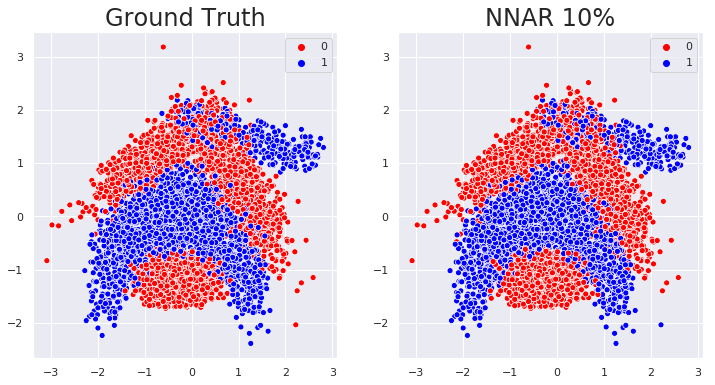

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(X[:,0], X[:,1], hue=y, ax=axes[0], palette=color_dict)
sns.scatterplot(X[:,0], X[:,1], hue=y_fig, ax=axes[1], palette=color_dict)
axes[0].set_title('Ground Truth', fontsize=24)
axes[1].set_title('NNAR 10%', fontsize=24)
# plt.show()
plt.savefig('%s_%s_0.10_viz.png' % (dataset, noise_type))

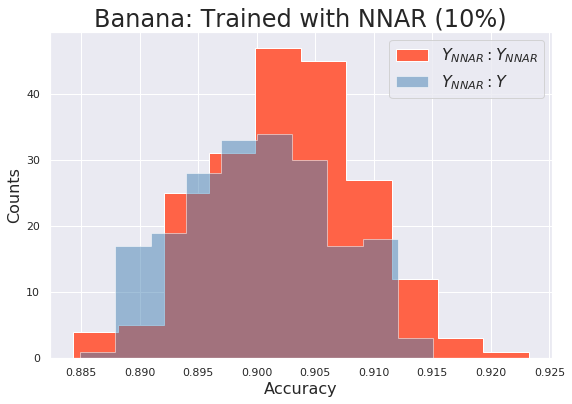

In [16]:
plt.figure(figsize=(9,6))
plt.hist(scores, label='$Y_{NNAR}:Y_{NNAR}$', color='tomato', histtype='stepfilled')
plt.hist(true_scores, label='$Y_{NNAR}:Y$', color='steelblue', histtype='stepfilled', alpha=0.5)
plt.title('Banana: Trained with NNAR (10%)', fontsize=24)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.legend(loc='best', fontsize=16)
# plt.show()
plt.savefig('%s_%s_0.10.png' % (dataset, noise_type))

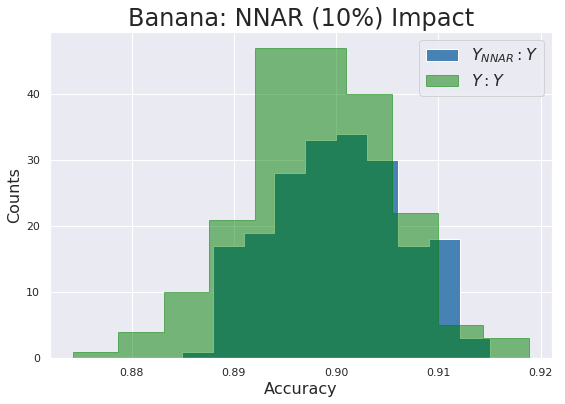

In [17]:
plt.figure(figsize=(9,6))
plt.hist(true_scores, label='$Y_{NNAR}:Y$', color='steelblue', histtype='stepfilled')
plt.hist(base_scores, label='$Y:Y$', color='green', edgecolor='green', histtype='stepfilled', alpha=0.5)
plt.title('Banana: NNAR (10%) Impact', fontsize=24)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.legend(loc='best', fontsize=16)
# plt.show()
plt.savefig('%s_%s_0.10_impact.png' % (dataset, noise_type))

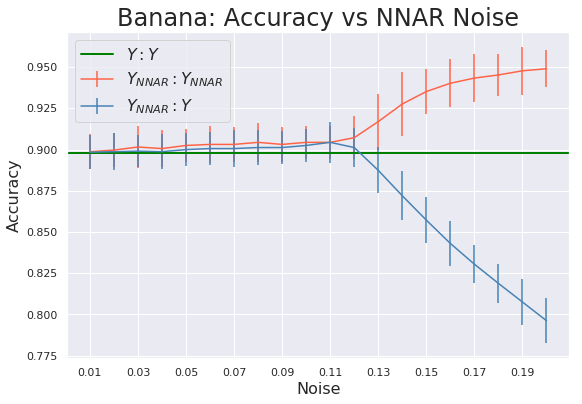

In [18]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, stats_scores[:,1], stats_scores[:,1] - stats_scores[:,0], color='tomato', label='$Y_{NNAR}:Y_{NNAR}$')
plt.errorbar(thresholds, stats_true_scores[:,1], stats_true_scores[:,1] - stats_true_scores[:,0], color='steelblue', label='$Y_{NNAR}:Y$')
plt.axhline(base_scores.mean(), color='green', lw=2, label='$Y:Y$')
plt.title('Banana: Accuracy vs NNAR Noise', fontsize=24)
plt.xlabel('Noise', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xticks(thresholds[::2])
# plt.show()
plt.savefig('%s_%s_all.png' % (dataset, noise_type))

# Tri-blobs

In [19]:
data = load_dill('tri_blobs/tri_blobs_nnar_0.05.dill')
X = data['X']
y = data['y']
y_nnars = data['y_new'][:num]
y_fig = y_nnars[0]

In [20]:
base_scores = []
idx = np.arange(y.shape[0])
for i in tqdm(range(num)):
    idx_train, idx_test = train_test_split(idx, test_size=0.3, stratify=y, random_state=i)
    clf = KNeighborsClassifier(n_neighbors=10).fit(X[idx_train], y[idx_train])
    y_pred = clf.predict(X[idx_test])
    base_scores.append(accuracy_score(y[idx_test], y_pred))
base_scores = np.array(base_scores)

100%|██████████| 200/200 [00:01<00:00, 140.15it/s]


In [ ]:
idx = np.arange(y.shape[0])
scores = []
true_scores = []
for i, y_nnar in enumerate(tqdm(y_nnars)):
    idx_train, idx_test = train_test_split(idx, test_size=0.3, stratify=y_nnar, random_state=i)
    clf = RandomForestClassifier(n_estimators=20).fit(X[idx_train], y_nnar[idx_train])
    y_pred = clf.predict(X[idx_test])
    scores.append(accuracy_score(y_nnar[idx_test], y_pred))
    true_scores.append(accuracy_score(y[idx_test], y_pred))
scores = np.array(scores)
true_scores = np.array(true_scores)

100%|██████████| 200/200 [00:13<00:00, 15.25it/s]


In [ ]:
dataset ='tri_blobs'
noise_type = 'nnar'
thresholds = np.arange(0.01, 0.21, 0.01)
stats_scores = []
stats_true_scores = []
for threshold in thresholds:
    print('noise_level = %0.2f' % threshold)
    # Load data
    data = load_dill('%s/%s_%s_%0.2f.dill' % (dataset, dataset, noise_type, threshold))
    X = data['X']
    y = data['y']
    y_nnars = data['y_new'][:num]
    
    idx = np.arange(y.shape[0])
    sub_scores = []
    sub_true_scores = []
    for i, y_nnar in enumerate(tqdm(y_nnars)):
        idx_train, idx_test = train_test_split(idx, test_size=0.3, stratify=y_nnar, random_state=i)
        clf = RandomForestClassifier(n_estimators=20).fit(X[idx_train], y_nnar[idx_train])
        y_pred = clf.predict(X[idx_test])
        sub_scores.append(accuracy_score(y_nnar[idx_test], y_pred))
        sub_true_scores.append(accuracy_score(y[idx_test], y_pred))
    stats_scores.append(np.percentile(sub_scores, [5,50,95]))
    stats_true_scores.append(np.percentile(sub_true_scores, [5,50,95]))
stats_scores = np.array(stats_scores)
stats_true_scores = np.array(stats_true_scores)

  1%|          | 2/200 [00:00<00:12, 15.36it/s]

noise_level = 0.01


  1%|          | 2/200 [00:00<00:13, 15.14it/s]

noise_level = 0.02


  1%|          | 2/200 [00:00<00:13, 14.23it/s]

noise_level = 0.03


  1%|          | 2/200 [00:00<00:13, 15.01it/s]

noise_level = 0.04


  1%|          | 2/200 [00:00<00:12, 15.61it/s]

noise_level = 0.05


  1%|          | 2/200 [00:00<00:13, 14.89it/s]

noise_level = 0.06


  1%|          | 2/200 [00:00<00:14, 14.01it/s]

noise_level = 0.07


  1%|          | 2/200 [00:00<00:13, 14.93it/s]

noise_level = 0.08


  1%|          | 2/200 [00:00<00:13, 14.49it/s]

noise_level = 0.09


  1%|          | 2/200 [00:00<00:12, 15.86it/s]

noise_level = 0.10


  1%|          | 2/200 [00:00<00:11, 16.71it/s]

noise_level = 0.11


  1%|          | 2/200 [00:00<00:11, 17.03it/s]

noise_level = 0.12


  1%|          | 2/200 [00:00<00:11, 16.59it/s]

noise_level = 0.13


  1%|          | 2/200 [00:00<00:11, 16.98it/s]

noise_level = 0.14


  1%|          | 2/200 [00:00<00:10, 18.18it/s]

noise_level = 0.15


  1%|          | 2/200 [00:00<00:11, 17.77it/s]

noise_level = 0.16


  1%|          | 2/200 [00:00<00:12, 15.69it/s]

noise_level = 0.17


  1%|          | 2/200 [00:00<00:11, 17.25it/s]

noise_level = 0.18


  1%|          | 2/200 [00:00<00:11, 17.87it/s]

noise_level = 0.19


  1%|          | 2/200 [00:00<00:12, 16.19it/s]

noise_level = 0.20


 17%|█▋        | 34/200 [00:01<00:09, 17.80it/s]

Generate figures

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(X[:,0], X[:,1], hue=y, ax=axes[0], palette=color_dict)
sns.scatterplot(X[:,0], X[:,1], hue=y_fig, ax=axes[1], palette=color_dict)
axes[0].set_title('Ground Truth', fontsize=24)
axes[1].set_title('NNAR 10%', fontsize=24)
# plt.show()
plt.savefig('%s_%s_0.10_viz.png' % (dataset, noise_type))

In [ ]:
plt.figure(figsize=(9,6))
plt.hist(scores, label='$Y_{NNAR}:Y_{NNAR}$', color='tomato', histtype='stepfilled')
plt.hist(true_scores, label='$Y_{NNAR}:Y$', color='steelblue', histtype='stepfilled', alpha=0.5)
plt.title('Tri-blobs: Trained with NNAR (10%)', fontsize=24)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.legend(loc='best', fontsize=16)
# plt.show()
plt.savefig('%s_%s_0.10.png' % (dataset, noise_type))

In [ ]:
plt.figure(figsize=(9,6))
plt.hist(true_scores, label='$Y_{NNAR}:Y$', color='steelblue', histtype='stepfilled')
plt.hist(base_scores, label='$Y:Y$', color='green', edgecolor='green', histtype='stepfilled', alpha=0.5)
plt.title('Tri-blobs: NNAR (10%) Impact', fontsize=24)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.legend(loc='best', fontsize=16)
# plt.show()
plt.savefig('%s_%s_0.10_impact.png' % (dataset, noise_type))

In [ ]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, stats_scores[:,1], stats_scores[:,1] - stats_scores[:,0], color='tomato', label='$Y_{NNAR}:Y_{NNAR}$')
plt.errorbar(thresholds, stats_true_scores[:,1], stats_true_scores[:,1] - stats_true_scores[:,0], color='steelblue', label='$Y_{NNAR}:Y$')
plt.axhline(base_scores.mean(), color='green', lw=2, label='$Y:Y$')
plt.title('Tri-blobs: Accuracy vs NNAR Noise', fontsize=24)
plt.xlabel('Noise', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.xticks(thresholds[::2])
# plt.show()
plt.savefig('%s_%s_all.png' % (dataset, noise_type))